In [17]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore") 

import sys
sys.path.append('../')
from Agnes import Agnes
from utils import report, plot_graphs, accuracy
from DBscan import DBscan 

cmap = 'Spectral'

In [18]:
data = pd.read_csv('datset.csv') 
cat = ['OverTime', 'MaritalStatus', 'JobRole', 'Gender', 'EducationField', 'Department', 'BusinessTravel', 'Attrition']
data = data.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis=1)
for i in cat:
    data[i] = (data[i].astype('category').cat.codes).apply(np.int64)
X, y = data.drop(['Attrition'], axis=1), data['Attrition']

In [19]:
X, y = np.array(X), list(y)

data_x = data.drop(['Attrition'], axis=1)
X_standardized = np.array((data_x - data_x.mean()) / data_x.std())
X_normalized = np.array(((data_x - data_x.min()) / (data_x.max() - data_x.min())))

In [20]:
def grid_search(eps_list, min_samples_list, X, dist_matrix, similarity):
    results = pd.DataFrame(columns=['eps', 'min_samples', 'nb_clusters', 'noise', 'score'])
    for eps in tqdm(eps_list):
        for min_samples in min_samples_list:
            dbscan = DBscan(eps=eps, min_samples=min_samples, similarity=similarity) 
            clusters = dbscan.cluster(X, dist_matrix=dist_matrix) 
            pred = np.copy(clusters)
            if -2 in pred:
                pred = np.array(list(pred).remove(-2))
            results = results.append({'eps': eps,
                                    'min_samples': min_samples,
                                    'nb_clusters': len(np.unique(pred)), 
                                    'noise': list(clusters).count(-2),
                                    'accuracy': accuracy(y, list(clusters)),
                                    'score': adjusted_rand_score(y, clusters)}, ignore_index=True)
    return results

# Hamming

## Grid Search

In [21]:
dist_matrix = np.load('..//Distance_matrices//Distances_Hamming.npy') 
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(0.3, 1.0)

In [22]:
eps_list = np.arange(0, 1, 0.05) 
min_samples_list = range(1, 20) 
results_H = grid_search(eps_list, min_samples_list, X, dist_matrix, 'hamming')

100%|██████████| 20/20 [02:19<00:00,  6.97s/it]


# Manhattan

## Grid Search

### Raw

In [23]:
dist_matrix = np.load('..//Distance_matrices//Distances_Manhattan.npy') 
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(105.0, 43646.0)

In [24]:
eps_list = range(100, 4000, 100)
min_samples_list = range(1, 20)
results_M = grid_search(eps_list, min_samples_list, X, dist_matrix, 'manhattan')

100%|██████████| 39/39 [04:59<00:00,  7.67s/it]


### Norm

In [25]:
dist_matrix = np.load('..//Distance_matrices//Distances_Manhattan_Norm.npy') 
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(1.6987427806585245, 19.499781669310412)

In [26]:
eps_list = np.arange(1, 20, 0.5)
min_samples_list = range(1, 20)
results_N = grid_search(eps_list, min_samples_list, X_normalized, dist_matrix, 'manhattan')

100%|██████████| 38/38 [08:11<00:00, 12.92s/it]


### Std

In [27]:
dist_matrix = np.load('..//Distance_matrices//Distances_Manhattan_Std.npy') 
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(6.306789533389955, 70.92801526813942)

In [28]:
eps_list = np.arange(6, 70, 1) 
min_samples_list = range(1, 20)
results_S = grid_search(eps_list, min_samples_list, X_standardized, dist_matrix, 'manhattan')

100%|██████████| 64/64 [15:45<00:00, 14.77s/it]


# Summary

## Best Accuracy

In [29]:
results_H['accuracy'].max(), results_M['accuracy'].max(), results_N['accuracy'].max(), results_S['accuracy'].max() 

(0.7223198594024605,
 0.6137440758293838,
 0.7223198594024605,
 0.7223198594024605)

In [30]:
print('Hamming-------------------')
print(results_H.loc[results_H['accuracy'].idxmax()])
print('Mnahattan-----------------')
print(results_M.loc[results_M['accuracy'].idxmax()]) 

Hamming-------------------
eps            0.95000
min_samples    1.00000
nb_clusters    1.00000
noise          0.00000
score          0.00000
accuracy       0.72232
Name: 361, dtype: float64
Mnahattan-----------------
eps            3900.000000
min_samples       1.000000
nb_clusters      23.000000
noise             0.000000
score            -0.051515
accuracy          0.613744
Name: 722, dtype: float64


In [31]:
print('Manhattan Norm-----------') 
print(results_N.loc[results_N['accuracy'].idxmax()])
print('Manhattan Std------------') 
print(results_S.loc[results_N['accuracy'].idxmax()])

Manhattan Norm-----------
eps            13.00000
min_samples     1.00000
nb_clusters     1.00000
noise           0.00000
score           0.00000
accuracy        0.72232
Name: 456, dtype: float64
Manhattan Std------------
eps            30.000000
min_samples     1.000000
nb_clusters     4.000000
noise           0.000000
score          -0.003269
accuracy        0.720141
Name: 456, dtype: float64


## 3D Plots

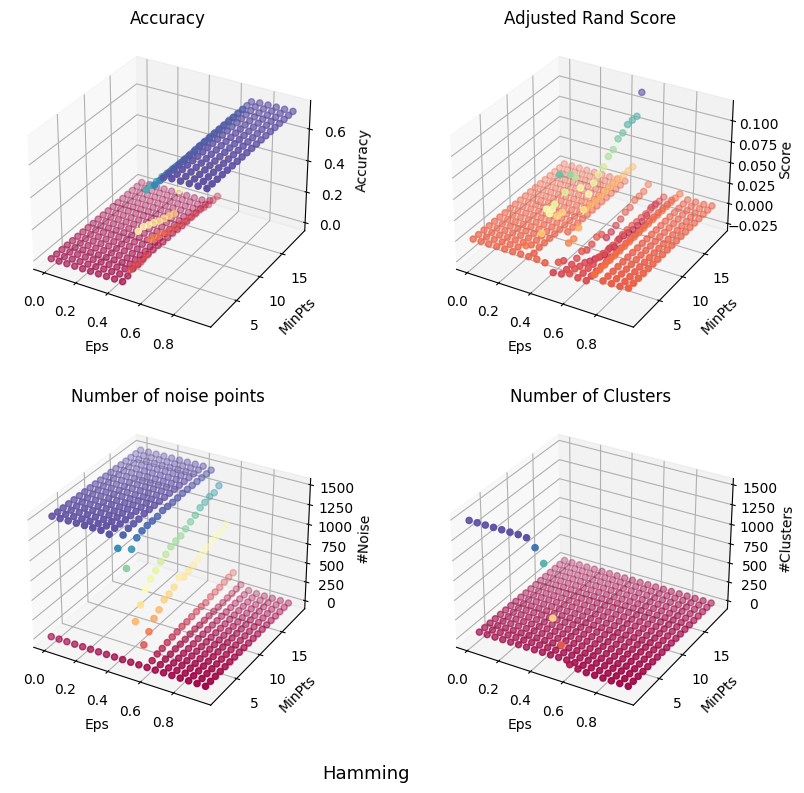

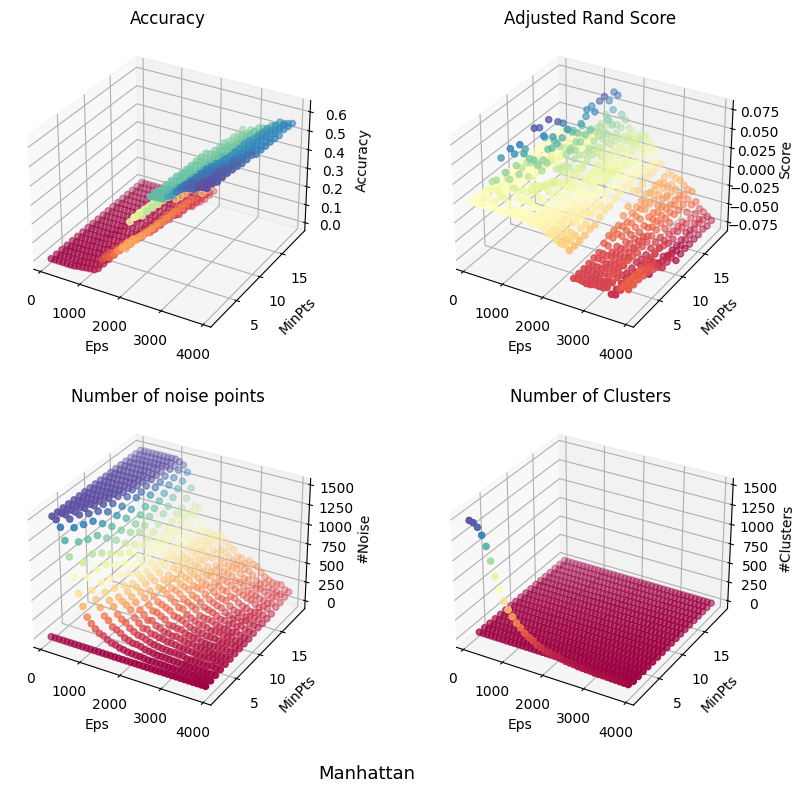

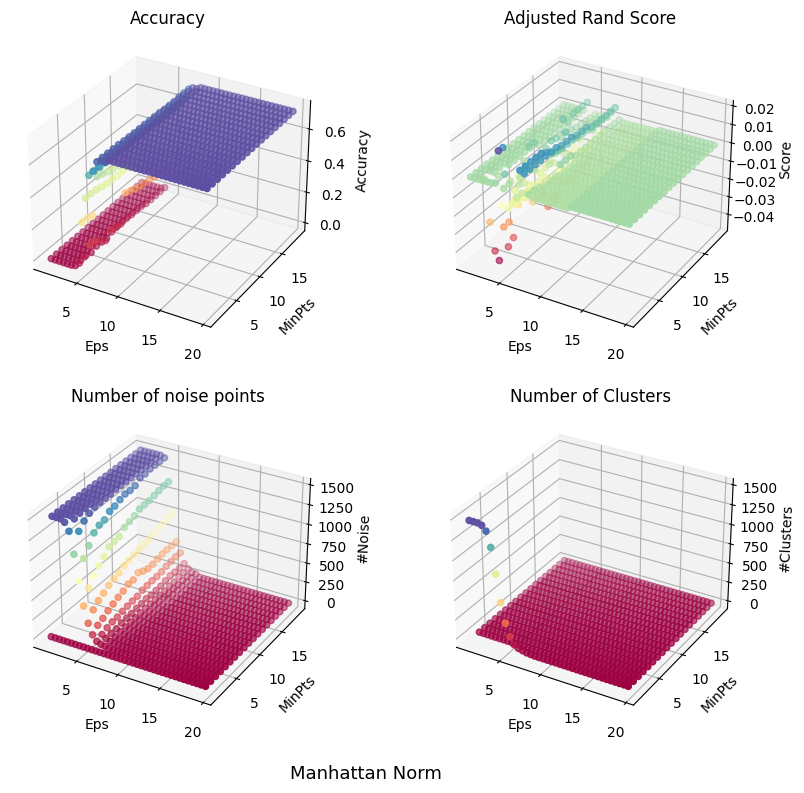

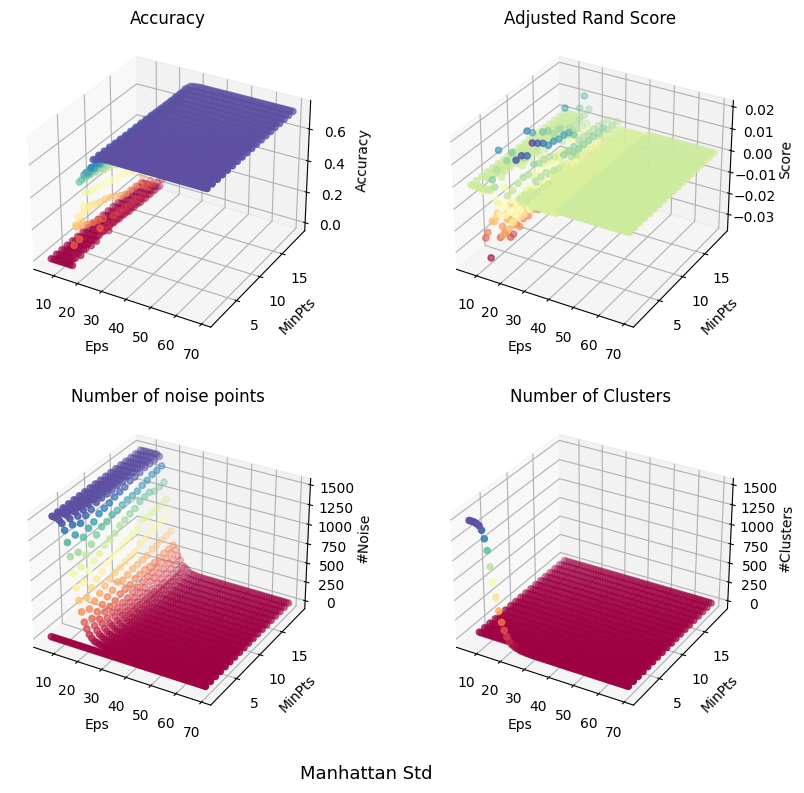

In [32]:
plot_graphs(results_H, 'Hamming')
plot_graphs(results_M, 'Manhattan')
plot_graphs(results_N, 'Manhattan Norm')
plot_graphs(results_S, 'Manhattan Std')  

## Best Accuracy / Noise per Eps

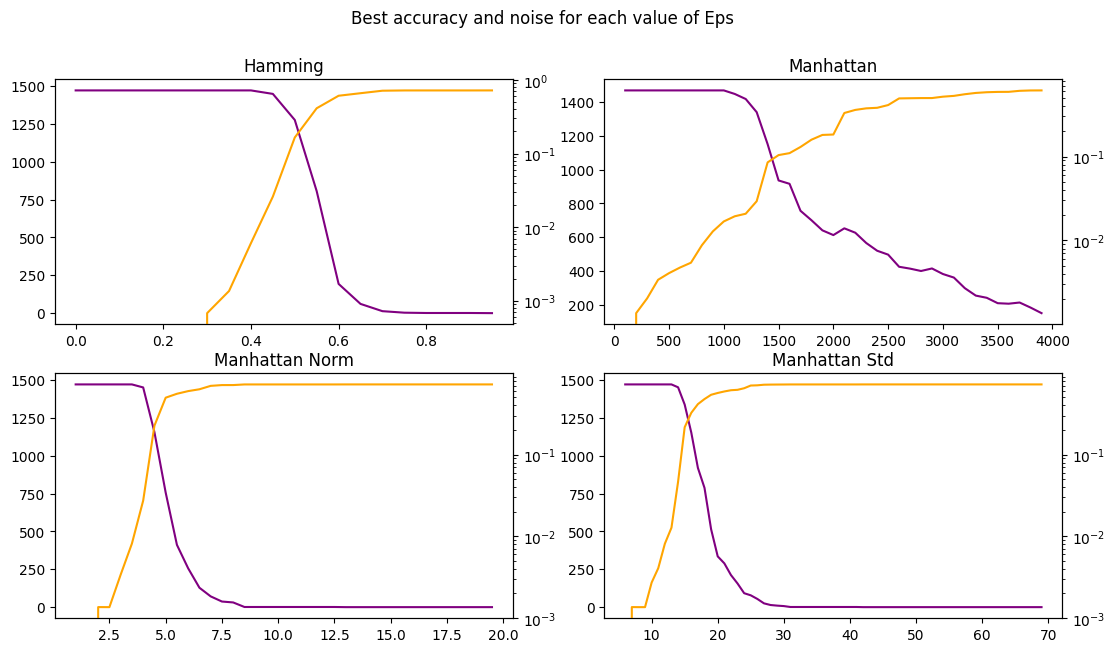

In [40]:
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
fig.set_size_inches(13, 7)

best_accuracies_H = results_H.groupby('eps')['noise'].max()
best_accuracies_M = results_M.groupby('eps')['noise'].max()
best_accuracies_N = results_N.groupby('eps')['noise'].max()
best_accuracies_S = results_S.groupby('eps')['noise'].max()

ax[0].plot(best_accuracies_H.index, best_accuracies_H.values, color='purple')
ax[1].plot(best_accuracies_M.index, best_accuracies_M.values, color='purple')
ax[2].plot(best_accuracies_N.index, best_accuracies_N.values, color='purple')
ax[3].plot(best_accuracies_S.index, best_accuracies_S.values, color='purple')

ax = [a.twinx() for a in ax]
for a in ax:
    a.set_yscale('log')

best_accuracies_H = results_H.groupby('eps')['accuracy'].max()
best_accuracies_M = results_M.groupby('eps')['accuracy'].max()
best_accuracies_N = results_N.groupby('eps')['accuracy'].max()
best_accuracies_S = results_S.groupby('eps')['accuracy'].max()

ax[0].plot(best_accuracies_H.index, best_accuracies_H.values, color='orange')
ax[0].set_title('Hamming')
ax[1].plot(best_accuracies_M.index, best_accuracies_M.values, color='orange')
ax[1].set_title('Manhattan')
ax[2].plot(best_accuracies_N.index, best_accuracies_N.values, color='orange')
ax[2].set_title('Manhattan Norm')
ax[3].plot(best_accuracies_S.index, best_accuracies_S.values, color='orange')
ax[3].set_title('Manhattan Std')

fig.suptitle('Best accuracy and noise for each value of Eps')

plt.show()

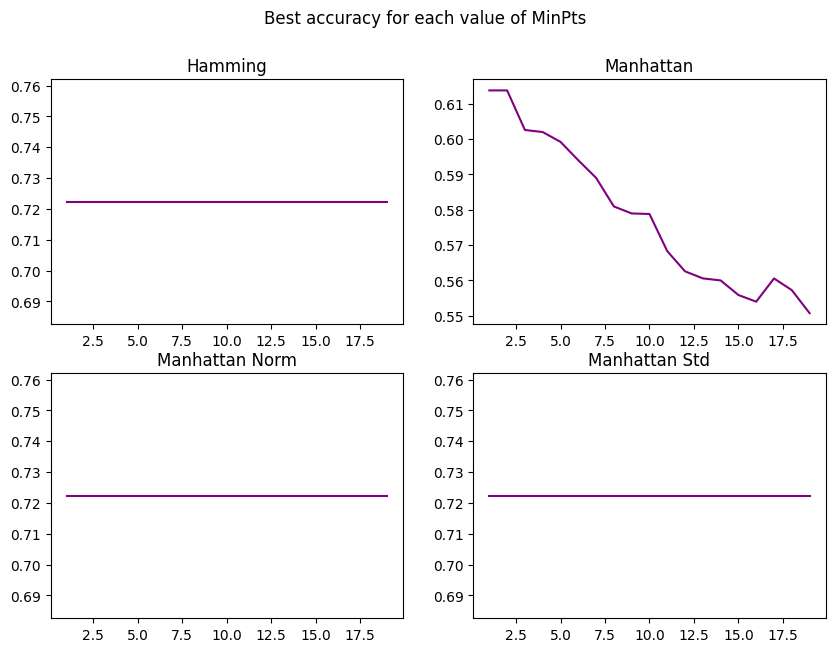

In [34]:
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
fig.set_size_inches(10, 7)

best_accuracies_H = results_H.groupby('min_samples')['accuracy'].max()
best_accuracies_M = results_M.groupby('min_samples')['accuracy'].max()
best_accuracies_N = results_N.groupby('min_samples')['accuracy'].max()
best_accuracies_S = results_S.groupby('min_samples')['accuracy'].max()

ax[0].plot(best_accuracies_H.index, best_accuracies_H.values, color='purple')
ax[0].set_title('Hamming') 
ax[1].plot(best_accuracies_M.index, best_accuracies_M.values, color='purple')
ax[1].set_title('Manhattan')
ax[2].plot(best_accuracies_N.index, best_accuracies_N.values, color='purple')
ax[2].set_title('Manhattan Norm')
ax[3].plot(best_accuracies_S.index, best_accuracies_S.values, color='purple')
ax[3].set_title('Manhattan Std')

fig.suptitle('Best accuracy for each value of MinPts')

plt.show()

## Heatmaps

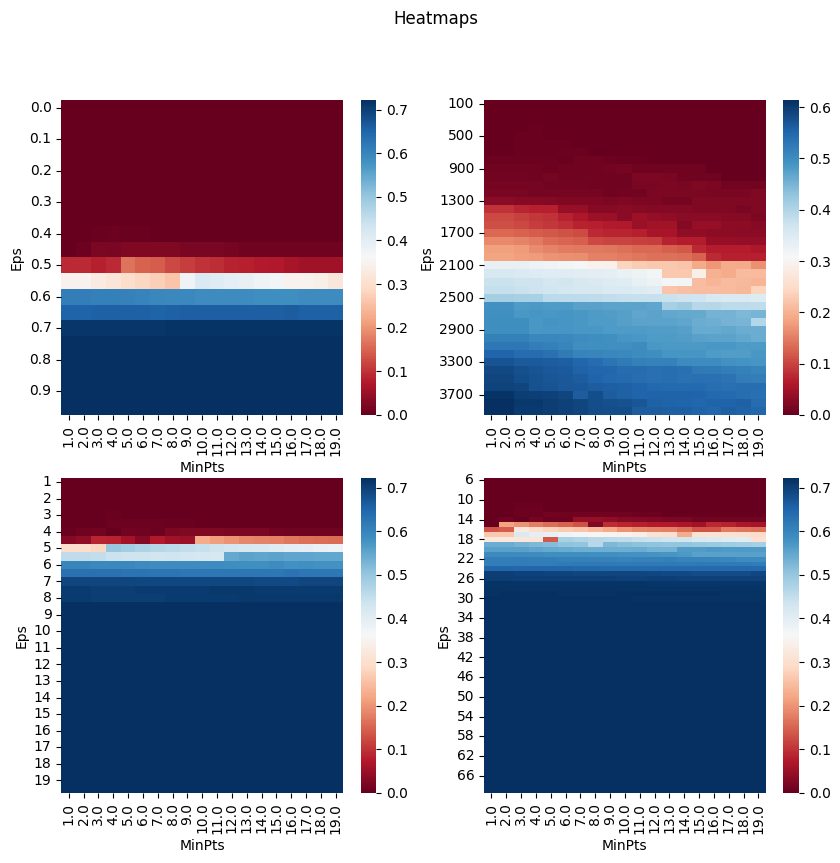

In [35]:
import seaborn as sns

fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
fig.set_size_inches(10, 9)

for ax, results, eps_range, title in zip(axs, [results_H, results_M, results_N, results_S], 
                                            [np.arange(0, 1, 0.1), range(100, 4000, 400), np.arange(1, 20, 1), np.arange(6, 70, 4)], 
                                            ['Hamming', 'Manhattan', 'Manhattan Norm', 'Manhattan Std']):
    hm_data = results.pivot(index='eps', 
                   columns='min_samples',
                   values='accuracy')

    sns.heatmap(hm_data,
                ax=ax,
                annot=False,
                cmap='RdBu',
                linecolor='white')

    if title in ['Manhattan Std', 'Manhattan']:
        ax.set_yticks(np.arange(0.5, len(eps_range)*4, 4))
    else:
        ax.set_yticks(np.arange(0.5, len(eps_range)*2, 2))
    ax.set_yticklabels([round(i, 2) for i in eps_range])

    #ax.set_title(title)
    ax.set_ylabel('Eps')
    ax.set_xlabel('MinPts')

fig.suptitle('Heatmaps')
plt.show()